# 14. 強化学習
> dataset: [CartPole](https://gym.openai.com/envs/CartPole-v1/)([利用規約](https://gym.openai.com/docs/))

所要時間：<font color="Red">3~5時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    print("Google Colab")
    # ライブラリのインストール
    !pip install torch==1.13.0 torchvision==0.14.0 gym==0.26.2
    !pip install pyglet==1.5.22 pyopengl==3.1.6 pyvirtualdisplay==3.0 pygame==2.5.0
    !apt install xvfb
else:
    print("Not Google Colab")

## DQNによるカートポールタスク（PyTorch）

DQN(Deep Q-Network)はQ関数をNNによって近似した手法です。

ある状態 $s$における行動 $a$ を入力として、その行動価値 $Q$ を出力します。

Q-learningのTD誤差は、

$$
\delta_t = r_{t+1}+\gamma \max_{a'}Q^{\pi}(s_{t+1},a') - Q^{\pi}(s_t,a_t)
$$

であるため、$r_{t+1}+\gamma \max_{a'}Q^{\pi}(s_{t+1},a')$と$Q^{\pi}(s_t,a_t)$の差の最小化することを目指します。

<br>

この手法は以下の制約を考慮することが出来ます。
- ある状態 $s$ では物理的に取り得ない行動 $a$ がある
- 最初からすべての行動が分かっていることは少ない


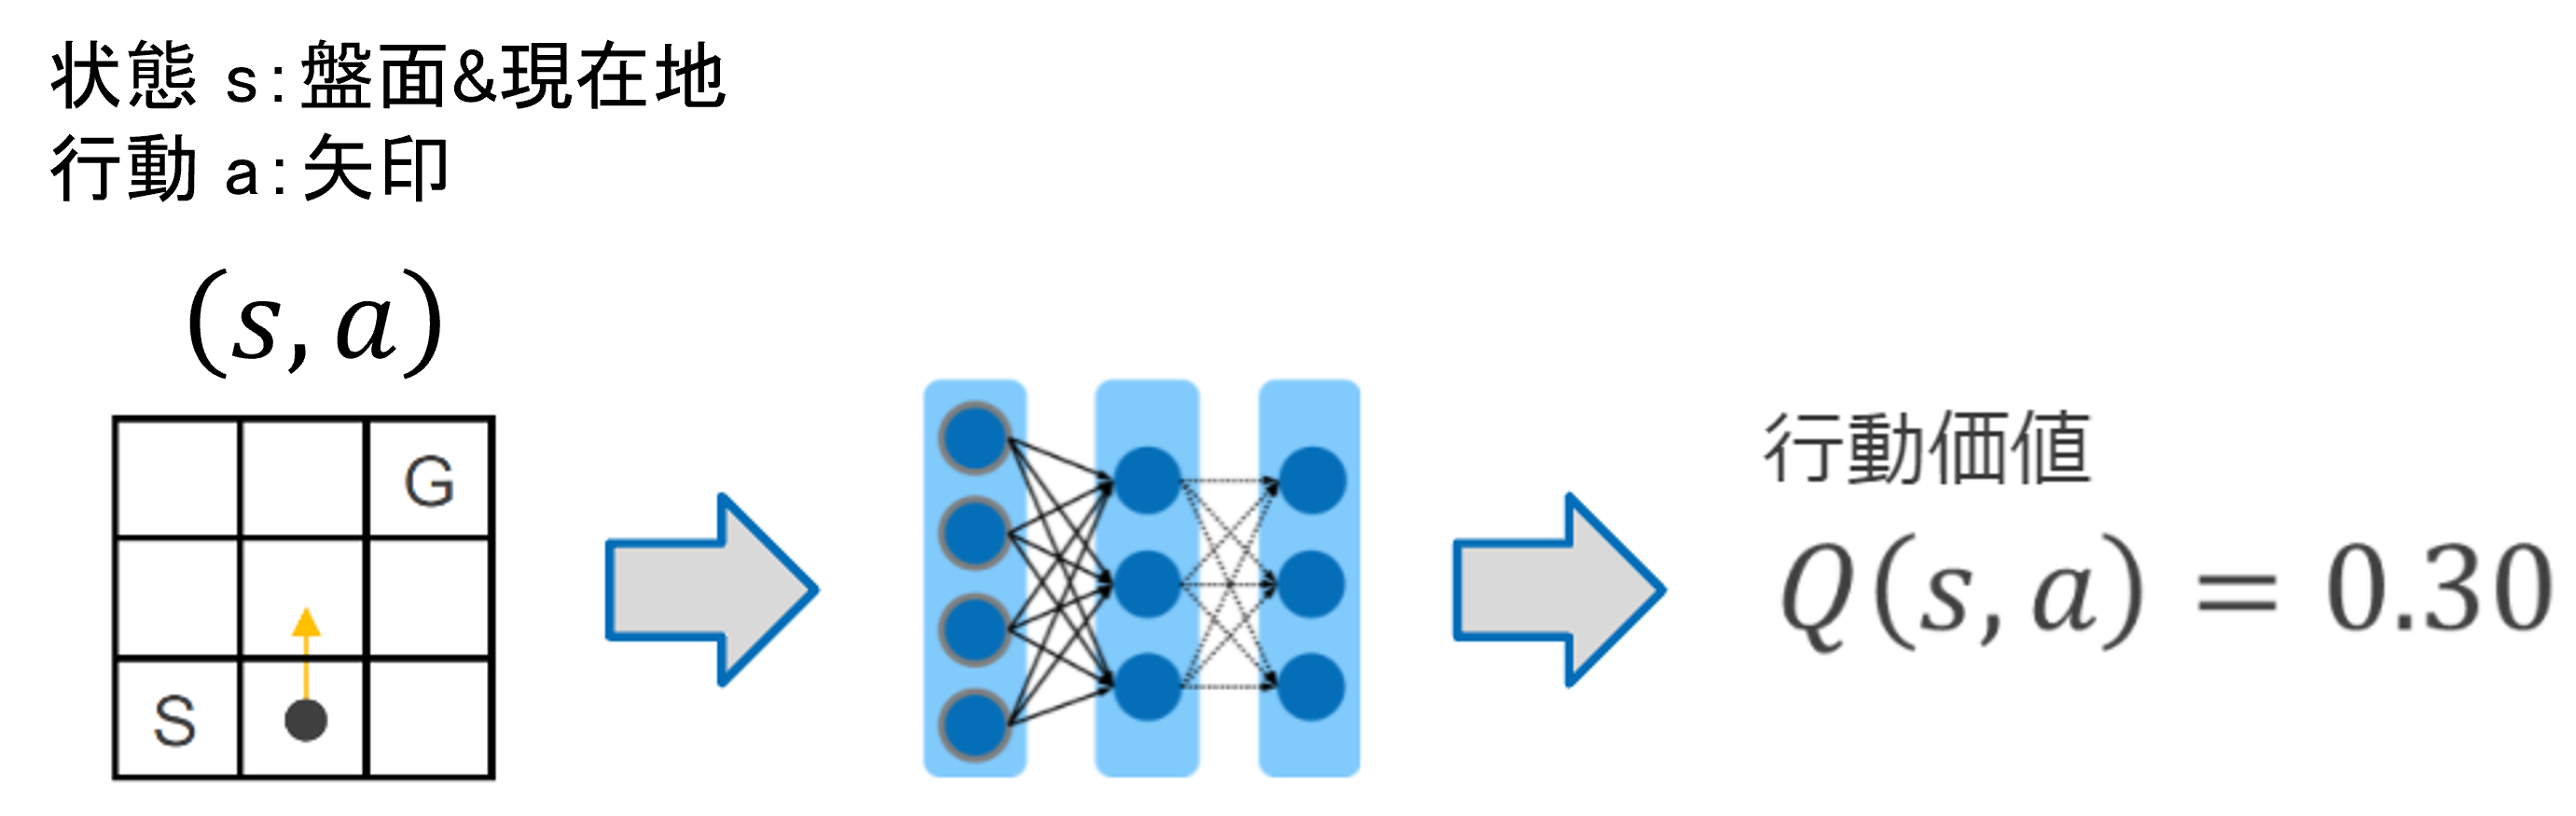

本Chapterで扱うタスクはカートポールタスクです。

カートポールタスクとは、左右に動くカートの上にポールを立て、倒れないように制御するタスクです。

今回は、`CartPole-v1`と呼ばれる台車に振り子が付いた環境を利用します。

強化学習における状態 $s$，行動 $a$、報酬 $r$ は以下の通りです。
```
【状態 s】
  ・カートの座標
  ・カートの速度
  ・ポールの角度
  ・ポールの角速度
【行動 a】
  ・左に動かす(0)または右に動かす(1)
【報酬 r】
  ・終端条件に達するまで常に+1
【終端条件】
  ・棒の角度が±12°より傾いたとき
  ・台車の位置が±2.4の範囲を外れたとき
  ・エピソードの長さが500ステップに達したとき
  ※エピソードとは行動が開始して終了するまでの期間です
```

### ライブラリのインポート

In [ ]:
import numpy as np
import copy
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import sys
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

### シミュレータ環境の構築

In [ ]:
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # Google colabでの実行コード
    from IPython import display
    from pyvirtualdisplay import Display
    
    d = Display()
    d.start()

    env=gym.make('CartPole-v1',render_mode='rgb_array')
    env.action_space.seed(123)

    (o,_)=env.reset()

    img = []
    for _ in range(100):
        o, r, d, i, _ = env.step(env.action_space.sample()) # Take action from DNN in actual training.

        display.clear_output(wait=True)
        img.append(env.render())

        if d:
            env.reset()

    dpi = 72
    interval = 50 # ms

    plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
    patch = plt.imshow(img[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
    display.display(display.HTML(ani.to_jshtml()))

else:
    # ローカルでの実行コード
    env=gym.make('CartPole-v1',render_mode='rgb_array')

    (state,_)=env.reset()

    frames = []
    for episode in range(5):
        (state,_)=env.reset()
        env.render()
        screen = env.render()
        frames.append(screen)
        done = False
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            env.render()
            screen = env.render()
            frames.append(screen)
    env.close()

## DQN

行動価値関数$Q$(以下、$Q$関数)を使い行動を決定します。

$Q(s,a)$を使用することで未来の状態を計算しなくても最適な行動ができます。

#### Q関数（クラス）
* <font color="Red">問1. スライド14章の処理を参考に、Q関数（クラス）のforward関数を完成させよう。活性化関数にはELU関数を使おう。</font><br>


In [ ]:
# Q関数の定義
class QNetwork(nn.Module):
    def __init__(self, num_state, num_action, hidden_size=16):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(num_state, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_action)
    
    def forward(self, x):
        ### 問1 ###
        y = F.elu(self.fc4(h))
        return y

#### リプレイバッファ関数（クラス）

DQNでは経験再生(experience reply)の利用を特徴とします。

経験リプレイとは、エージェントが経験した状態と行動をメモリに保存しておき、学習時にランダムにメモリから情報と行動をピックアップして学習する手法です。

<br>

ここでは、リプレイバッファクラスを実装します。リプレイバッファにこれまでの状態遷移を記録しておき、そこからサンプリングすることでＱ関数のミニバッチ学習を行います。

<br>

<font color="Red">問2. 【リプレイバッファ関数】```batch_indexes```に0以上```len(self.memory)```未満の整数列を、バッチサイズと同じ次元で生成できるようにしたい。np.random内の関数を用いて実現しよう。</font><br>

In [ ]:
# リプレイバッファの定義
class ReplayBuffer:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque([], maxlen=memory_size)
    
    def append(self, transition):
        self.memory.append(transition)
    
    def sample(self, batch_size):
        batch_indexes =  ### 問2 ###
        states      = np.array([self.memory[index]['state'] for index in batch_indexes])
        next_states = np.array([self.memory[index]['next_state'] for index in batch_indexes])
        rewards     = np.array([self.memory[index]['reward'] for index in batch_indexes])
        actions     = np.array([self.memory[index]['action'] for index in batch_indexes])
        dones   = np.array([self.memory[index]['done'] for index in batch_indexes])
        return {'states': states, 'next_states': next_states, 'rewards': rewards, 'actions': actions, 'dones': dones}

#### Agentクラス

・Agentによる行動選択

学習中、行動価値関数$Q$は割引率 $\gamma$と学習率 $\alpha$を用いて以下の式で更新します。

$$
Q^{\pi}(s_t,a_t) \leftarrow Q^{\pi}(s_t,a_t)+\alpha \left(r_{t+1}+\gamma \max_{a'}Q^{\pi}(s_{t+1},a') -Q^{\pi}(s_t,a_t)\right)
$$

ただし、学習する対象のQ関数$Q^{\pi}(s_t,a_t)$も、更新によって近づける目標値$r_{t+1}+\gamma \max_{a'}Q^{\pi}(s_{t+1},a')$もどちらも同じパラメータを持つQ関数を利用しています。

そのため、そのまま勾配法による最適化を行うと元のQ値と目標値の両方が更新されてしまうことになります。

これを避けるために、目標値$r_{t+1}+\gamma \max_{a'}Q^{\pi}(s_{t+1},a')$は固定した上でQ関数の最適化を行います。

Q値の更新に利用する行動 $a$ は、Q関数が最大となる行動を決定的に選択します。

<br>
<br>

方策$\pi$として、小さい確率$\epsilon$で一様な確率でランダムな行動を選択し、それ以外は最もQ値（の推定値）が最も高い行動を選択する、**ε-greedy方策**が用いられることが多いです。

ランダムな行動を選択することで、探索を促進するために利用されます。

<br>
<br>

* <font color="Red">問3. ```torch.max```関数を使って、Agentのうち```maxq```にQ値の最大値を計算して格納する処理を完成させよう</font><br>

* <font color="Red">問4. ε-greedyに行動を選択する際、```epsilon```が0以上1以下で生成された一様乱数より小さければQ値が最大の行動が選択される。この処理をif文で記述しよう。</font><br>

In [ ]:
# DQNAgentクラス
class DqnAgent:
    def __init__(self, num_state, num_action, gamma=0.99, lr=0.001, batch_size=32, memory_size=50000):
        self.num_state = num_state
        self.num_action = num_action
        self.gamma = gamma  # 割引率
        self.batch_size = batch_size  # Q関数の更新に用いる遷移の数
        self.qnet = QNetwork(num_state, num_action)
        self.target_qnet = copy.deepcopy(self.qnet)  # ターゲットネットワーク
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(memory_size)
    
    # Q関数を更新
    def update_q(self):
        batch = self.replay_buffer.sample(self.batch_size)
        q = self.qnet(torch.tensor(batch["states"], dtype=torch.float))
        targetq = copy.deepcopy(q.data.numpy())
        # maxQの計算
        maxq = ### 問3 ###
        # Q値が最大の行動だけQ値を更新（最大ではない行動のQ値はqとの2乗誤差が0になる）
        for i in range(self.batch_size):
            # 終端状態の場合はmaxqを0にしておくと学習が安定する
            targetq[i, batch["actions"][i]] = batch["rewards"][i] + self.gamma * maxq[i] * (not batch["dones"][i]) 
        self.optimizer.zero_grad()
        # lossとしてMSEを利用
        loss = nn.MSELoss()(q, torch.tensor(targetq))
        loss.backward()
        self.optimizer.step()
        # ターゲットネットワークのパラメータを更新
        self.target_qnet = copy.deepcopy(self.qnet)
    
    # Q値が最大の行動を選択
    def get_greedy_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float).view(-1, self.num_state)
        action = torch.argmax(self.qnet(state_tensor).data).item()
        return action
    
    # ε-greedyに行動を選択
    def get_action(self, state, episode):
        epsilon = 0.7 * (1/(episode+1))  # ここでは0.5から減衰していくようなεを設定
        if epsilon <= ### 問4 ### :
            action = self.get_greedy_action(state)
        else:
            action = np.random.choice(self.num_action)
        return action

In [ ]:
# 各種設定
num_episode = 300  # 学習エピソード数
memory_size = 50000  # replay bufferの大きさ
initial_memory_size = 500  # 最初に貯めるランダムな遷移の数

# ログ
episode_rewards = []
num_average_epidodes = 10

env=gym.make('CartPole-v1',render_mode='rgb_array')
max_steps = env.spec.max_episode_steps  # エピソードの最大ステップ数

agent = DqnAgent(env.observation_space.shape[0], env.action_space.n, memory_size=memory_size)

# 最初にreplay bufferにランダムな行動をしたときのデータを入れる
(state, _) = env.reset()
for step in range(initial_memory_size):
    action = env.action_space.sample() # ランダムに行動を選択        
    next_state, reward, done, _, _ = env.step(action)
    transition = {
        'state': state,
        'next_state': next_state,
        'reward': reward,
        'action': action,
        'done': int(done)
    }
    agent.replay_buffer.append(transition)
    if done:
        (state, _) = env.reset()
    else:
        state = next_state

for episode in range(num_episode):
    (state, _) = env.reset()  # envからは4次元の連続値の観測が返ってくる
    episode_reward = 0
    for t in range(max_steps):
        action = agent.get_action(state, episode)  # 行動を選択
        next_state, reward, done, _, _ = env.step(action)
        episode_reward += reward
        transition = {
            'state': state,
            'next_state': next_state,
            'reward': reward,
            'action': action,
            'done': int(done)
        }
        agent.replay_buffer.append(transition)
        agent.update_q()  # Q関数を更新
        state = next_state
        if done:
            break
    episode_rewards.append(episode_reward)
    if episode % 20 == 0:
        print("Episode %d finished | Episode reward %f" % (episode, episode_reward))

# 累積報酬の移動平均を表示
moving_average = np.convolve(episode_rewards, np.ones(num_average_epidodes)/num_average_epidodes, mode='valid')
plt.plot(np.arange(len(moving_average)),moving_average)
plt.title('DQN: average rewards in %d episodes' % num_average_epidodes)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

env.close()

### 最終的に得られた方策のテスト（可視化）

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []
for episode in range(5):
    (state,_)=env.reset()
    env.render()
    screen = env.render()
    frames.append(screen)
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)
        env.render()
        screen = env.render()
        frames.append(screen)
env.close()

In [ ]:
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])

def animate(i):
    patch.set_data(frames[i])
    
anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())